# Assignment No 1
## Paper Number 5 
## Title: Sharp transition towards shared vocabularies in multi-agent systems
Baronchelli et al.'s research investigates how agent populations can create common vocabulary without the need for generational transmission or central coordination.  The "Naming Game" microscopic model is the subject of the study, in which agents must use local interactions to agree on common words for things.

In [94]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import Dependancies
This part of the code imports necessary Python libraries for the implementation of the Naming Game model:

Mesa: An agent-based modeling framework that provides a structure for implementing the model

NumPy: For numerical operations and array handling

Pandas: For data manipulation and analysis

Seaborn: For statistical data visualization

Matplotlib: For creating plots and graphs

Random: For generating random values

The debug flags (DEBUGVOCAB and DEBUGSTEP) are also set to control console output during execution.

In [95]:
#!/usr/bin/env python3.11
!python --version

import mesa
print(f"mesa version: {mesa.__version__}")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

DEBUGVOCAB = False
DEBUGSTEP = False

Python 3.12.6
mesa version: 3.1.5


# The Naming Game

The Naming Game paradigm, as presented in the study "Sharp transition towards shared vocabularies in multi-agent systems" by Baronchelli et al., is introduced in this section.  Without centralized coordination, the model models how a population of agents can converge on a common lexicon.
 The Naming Game's primary mechanisms consist of:

 Agents attempting to establish a shared object vocabulary
 
 Pairwise exchanges in which agents discuss things
 
 When the hearer understands the word the speaker used, success
 
 Learning occurs when the hearer fails to recognize the term.

## Create Random Word:
This function generates random words of varying lengths to be used by agents in the naming game

It creates a random string of uppercase letters with a length between the specified minimum and maximum values.

In [97]:
from random import choice
from string import ascii_uppercase

def create_word(min_length=6, max_length=10):
    new_word = ''.join(choice(ascii_uppercase) for _ in range(np.random.randint(min_length, max_length)))
    return new_word

## Create Agent:
This section defines the NamingGameAgent class that implements the agent behavior as described in the paper:

Agents have vocabularies represented as dictionaries mapping objects to lists of words

They can choose objects and words from their vocabulary

They can recognize words used by other agents

They can update their vocabularies based on interactions (agreement, adding new words)

The class follows the core logic of the paper, where agents communicate about objects using words and update their vocabularies based on the success or failure of their interactions.

In [98]:
class NamingGameAgent(mesa.Agent):
    def __init__(self, model, m_objects=1):
        super().__init__(model)
        self._m_objects = m_objects
        self.vocabulary = dict()

    def choose_object_and_word(self):
        #chosen from range will always choose 0 index object value, so m_objects = 1 -> chosen object is 0
        chosen_object = np.random.randint(0, self._m_objects)
        
        if chosen_object in self.vocabulary.keys():
            chosen_word = random.choice(self.vocabulary[chosen_object])
        else:
            chosen_word = create_word()
            self.vocabulary[chosen_object] = [chosen_word]
        return chosen_object, chosen_word

    def recognize_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            return False
        if chosen_word in self.vocabulary[chosen_object]:
            return True
        else:
            return False

    def agree_to_word(self, chosen_object, chosen_word):
        self.vocabulary[chosen_object] = [chosen_word]

    def add_word(self, chosen_object, chosen_word):
        if chosen_object not in self.vocabulary.keys():
            self.vocabulary[chosen_object] = [chosen_word]
        else:
            self.vocabulary[chosen_object].append(chosen_word)

    def retrieve_vocabulary(self):
        return [f"Object: {key} - words: {value}" for key, value in self.vocabulary.items()]
    
    def word_amount(self):
        return sum([len(word_list) for word_list in self.vocabulary.values()])

### Class for computing successrate:
The SuccessRate class tracks and calculates the success rate of interactions between agents over time, implementing a rolling window approach to measure how often communication is successful:

In [99]:
class SuccessRate(list):
    def __init__(self, maxlen=10):
        super().__init__()
        self._maxlen = maxlen
    
    def add(self, value):
        if type(value) != int:
            raise TypeError("Only integers are allowed in SuccessRate")
        if len(self) >= self._maxlen:
            self.pop(0)
        self.append(value)
    
    def get_rate(self):
        return sum(self)/len(self) if self else 0

    def get_values(self):
        return list(self)

### Create Model
The NamingGameModel class uses Mesa's framework to implement the Naming Game model. Key aspects include:

Initializing a population of agents
Implementing the step function that governs agent interactions
Collecting data on total word count, unique words, and success rate
Tracking when the model reaches convergence (shared vocabulary)

This directly implements the algorithm from the Baronchelli paper, where random pairs of agents interact and update their vocabularies based on the success or failure of their communication.

In [106]:
from mesa.datacollection import DataCollector

class NamingGameModel(mesa.Model):
    def __init__(self, N=100, m_objects=1, seed=None, data_resolution=100, detailed_info=True):
        super().__init__(seed=seed)
        self._detailed_info = detailed_info
        self._data_resolution = data_resolution
        self.max_words = 0
        self.max_time = 0
        self.conv_time = -1
        self.num_agents = N
        self.success_rate = SuccessRate(maxlen=1000)
        self.datacollector = DataCollector(
            model_reporters={"Success_rate": self.success_rate.get_rate,
                             #"Success_rate_values": self.success_rate.get_values,
                             "Total_word_amount": "total_word_amount",
                             "Total_unique_word_amount": "total_unique_word_amount"}
        )
        self.simple_datacollector = DataCollector(
            model_reporters={"Success_rate": self.success_rate.get_rate,
                             "Total_word_amount": "total_word_amount"}
        )
        self.m_objects = m_objects
        NamingGameAgent.create_agents(model=self, n=N, m_objects=m_objects)

    def update_max_words(self):
        if self.max_words < self.total_word_amount:
            self.max_words = self.total_word_amount
            self.max_time = self.steps
    
    def check_convergence(self):
        if self.total_unique_word_amount == self.m_objects and self.conv_time == -1:
            self.conv_time = self.steps
    
    def step(self):
        if self.steps % self._data_resolution == 0:
            if self._detailed_info:
                self.datacollector.collect(self)
            else:
                self.simple_datacollector.collect(self)
                self.update_max_words()
                self.check_convergence()
        speaker, hearer = random.sample(self.agents, 2)
        if self.steps % 100 == 0 and DEBUGVOCAB:
            if speaker.word_amount() != 0:
                print(speaker.word_amount())
                print(speaker.retrieve_vocabulary())
        chosen_object, chosen_word = speaker.choose_object_and_word()
        if hearer.recognize_word(chosen_object, chosen_word):
            self.success_rate.add(1)
            speaker.agree_to_word(chosen_object, chosen_word)
            hearer.agree_to_word(chosen_object, chosen_word)
        else:
            self.success_rate.add(0)
            hearer.add_word(chosen_object, chosen_word)

    @property
    def total_word_amount(self):
        return sum([agent.word_amount() for agent in self.agents])

    @property
    def total_unique_word_amount(self):
        unique_words = set()
        for agent in self.agents:
            for word_list in agent.vocabulary.values():
                unique_words.update(word_list)
        return len(unique_words)


### Run Model function
This function executes the model for a specified number of time steps and collects data:

In [101]:
def run_model(N, M, t, iteration, data_resolution=100):
    print(f"Starting model iteration: {iteration}")
    model = NamingGameModel(N, M, data_resolution=data_resolution)
    for i in range(t):
        if i % int(t/10) == 0 and DEBUGSTEP:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data

### Run model configuration for figure 2

This section runs multiple simulations of the model to reproduce Figure 2 from the paper, tracking:

Total number of words in the system over time
Number of unique words over time
Success rate over time

It runs the model with N=1000 agents and collects both average results across multiple runs and individual run data for comparison.

In [107]:
N = 1000
M = 1
t = 100000
DATA_RESOLUTION = 50

RUNS = 3
single_run1 = np.random.randint(0, int(RUNS/2)+1)
single_run2 = min(int(RUNS-1), int(RUNS - single_run1))
print(single_run1)
print(single_run2)

model_df = pd.DataFrame()
single_run1_model_data, single_run2_model_data = pd.DataFrame(), pd.DataFrame()
for i in range(RUNS):
    model_data = run_model(N=N, M=M, t=t, iteration=i+1, data_resolution=DATA_RESOLUTION)
    if i == single_run1:
        single_run1_model_data = model_data
    if i == single_run2:
        single_run2_model_data = model_data
    
    if model_df.empty:
        model_df = model_data
    else:
        model_df = (model_df + model_data) / 2

0
2
Starting model iteration: 1
Starting model iteration: 2
Starting model iteration: 3


### Datacollection Dataframes
This displays the collected data in a tabular format, showing how the metrics change over time.

In [108]:
model_df

,Success_rate,Total_word_amount,Total_unique_word_amount
0,0.0,94.75,45.75
1,0.0,189.25,90.25
2,0.0,282.00,133.00
3,0.0,366.25,167.25
4,0.0,444.25,195.25
...,...,...,...
1995,1.0,1000.00,1.00
1996,1.0,1000.00,1.00
1997,1.0,1000.00,1.00
1998,1.0,1000.00,1.00


### Create Graphs and Figures
This section creates visualizations similar to Figure 2 from the paper:

Total number of words vs. time

Total number of unique words vs. time

Success rate vs. time, with an inset showing the early behavior compared to the theoretical prediction (S(t) = 3t/N²)

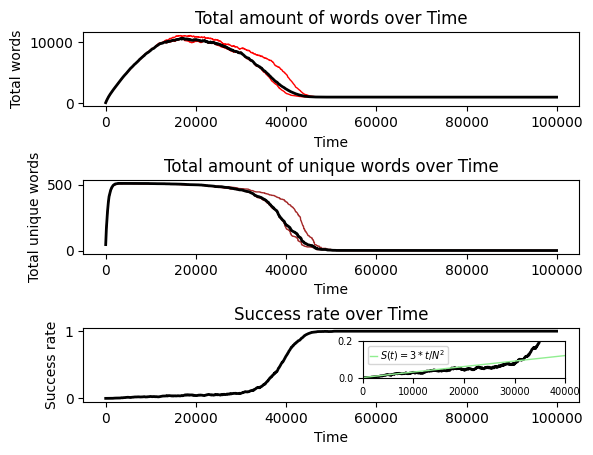

In [119]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

model_df["scaled_index"] = model_df.index * DATA_RESOLUTION
single_run1_model_data["scaled_index"] = single_run1_model_data.index * DATA_RESOLUTION
single_run2_model_data["scaled_index"] = single_run2_model_data.index * DATA_RESOLUTION
fig, axs = plt.subplots(nrows=3)

#figure showing all total words over time
g = sns.lineplot(data=single_run1_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="red", linewidth=1)
g = sns.lineplot(data=model_df[["Total_word_amount", "scaled_index"]], x="scaled_index", y="Total_word_amount", 
                 ax=axs[0], color="black", linewidth=2)
g.set(title="Total amount of words over Time", ylabel="Total words", xlabel="Time")

#figure showing all unique words over time
g = sns.lineplot(data=single_run1_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=single_run2_model_data[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="brown", linewidth=1)
g = sns.lineplot(data=model_df[["Total_unique_word_amount", "scaled_index"]], x="scaled_index", y="Total_unique_word_amount", 
                 ax=axs[1], color="black", linewidth=2)
g.set(title="Total amount of unique words over Time", ylabel="Total unique words", xlabel="Time")

#figure showing all successful interactions over time
g = sns.lineplot(data=model_df[["Success_rate", "scaled_index"]], x="scaled_index", y="Success_rate", 
                 ax=axs[2], color="black", linewidth=2)
g.set(title="Success rate over Time", ylabel="Success rate", xlabel="Time")

#smaller figure showing succesful interactions over time with overlaid s(t)=3t/N^2
ax_inset = inset_axes(axs[2], width="85%", height="90%", loc='center left',
                      bbox_to_anchor=(0.55, 0.3, 0.48, 0.55), bbox_transform=axs[2].transAxes)

x = model_df["scaled_index"]
inset_y = model_df["Success_rate"]
y = 3 * x / N**2
ax_inset.plot(x, inset_y, 
              color="black", linewidth=2)
ax_inset.plot(x, y, 
              color='lightgreen', label=r'$S(t) = 3*t/{N^2}$', linewidth=1)

#zoom
ax_inset.set_xlim(0, 40000)
ax_inset.set_ylim(0, 0.2)
ax_inset.tick_params(axis='both', labelsize=7)
ax_inset.legend(fontsize=7, 
                borderpad=0.2, 
                handlelength=0.8, 
                handletextpad=0.3, 
                labelspacing=0.2, 
                frameon=True)

#mark_inset(axs[2], ax_inset, loc1=2, loc2=4, fc="none", ec="0.5") #TODO ask if this is too messy

plt.subplots_adjust(hspace=1)

### Run Model for simple datacollection
A simplified version of the model runner that collects only essential metrics:

In [110]:
def run_simple_model(N, M, t, iteration, data_resolution=1000):
    print(f"Starting model iteration: {iteration}")
    model = NamingGameModel(N, M, data_resolution=data_resolution, detailed_info=False)
    for i in range(t):
        if i % int(t/10) == 0 and DEBUGSTEP:
            print(f"iter: {iteration}, step: {i}")
            
        model.step()

    model_data = model.simple_datacollector.get_model_vars_dataframe()
    return model_data, model.max_words, model.max_time, model.conv_time

### Run model configuration for figure 3

This section runs simulations with different population sizes to reproduce Figure 3 from the paper:

Scaling of peak time and convergence time with population size

Scaling of maximum number of words with population size

Success rate curves for different system sizes

In [125]:
DATAPOINTS = 12
n_log = np.logspace(1, 3.5, DATAPOINTS, base=10, dtype=int)
n_st = [60, 100, 300, 600, 1000, 3000]
M = 1
t = 500000
DATARESOLUTION = 20

s_t_list = []
t_list = []
max_time_list = []
max_words_list = []
conv_time_list = []

for n in n_log:
    _, max_words, max_time, conv_time  = run_simple_model(N=n, M=M, t=t, iteration=n, data_resolution=DATARESOLUTION)
    max_time_list.append(max_time)
    max_words_list.append(max_words)
    conv_time_list.append(conv_time)

df = pd.DataFrame({
    'max_time': max_time_list,
    'conv_time': conv_time_list,
    'max_words': max_words_list
})

for n in n_st:
    model_data, _, _, _ = run_simple_model(N=n, M=M, t=t, iteration=n, data_resolution=DATARESOLUTION)

    s_t_list.append(model_data["Success_rate"])

Starting model iteration: 10
Starting model iteration: 16
Starting model iteration: 28
Starting model iteration: 48
Starting model iteration: 81
Starting model iteration: 136
Starting model iteration: 231
Starting model iteration: 389
Starting model iteration: 657
Starting model iteration: 1110
Starting model iteration: 1873
Starting model iteration: 3162
Starting model iteration: 60
Starting model iteration: 100
Starting model iteration: 300
Starting model iteration: 600
Starting model iteration: 1000
Starting model iteration: 3000


In [126]:
df

,max_time,conv_time,max_words
0,40,100,12
1,40,180,28
2,80,260,59
3,320,820,124
4,560,1720,322
5,840,3800,528
6,1680,5560,1164
7,4520,14980,2695
8,8860,26700,5473
9,25420,57760,12662


In [127]:
s_t_list

[0        0.052632
 1        0.025641
 2        0.016949
 3        0.037975
 4        0.040404
            ...   
 24995    1.000000
 24996    1.000000
 24997    1.000000
 24998    1.000000
 24999    1.000000
 Name: Success_rate, Length: 25000, dtype: float64,
 0        0.000000
 1        0.025641
 2        0.016949
 3        0.012658
 4        0.010101
            ...   
 24995    1.000000
 24996    1.000000
 24997    1.000000
 24998    1.000000
 24999    1.000000
 Name: Success_rate, Length: 25000, dtype: float64,
 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 24995    1.0
 24996    1.0
 24997    1.0
 24998    1.0
 24999    1.0
 Name: Success_rate, Length: 25000, dtype: float64,
 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 24995    1.0
 24996    1.0
 24997    1.0
 24998    1.0
 24999    1.0
 Name: Success_rate, Length: 25000, dtype: float64,
 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        

### Graphs and figures for figure 3
Creates visualizations similar to Figure 3 from the paper:

Log-log plot of characteristic times (tmax and tconv) vs. population size N

Log-log plot of maximum number of words vs. population size N

Success rate curves for different system sizes, normalized to show the sharpening transition

Collapsed success rate curves demonstrating universal scaling behavior

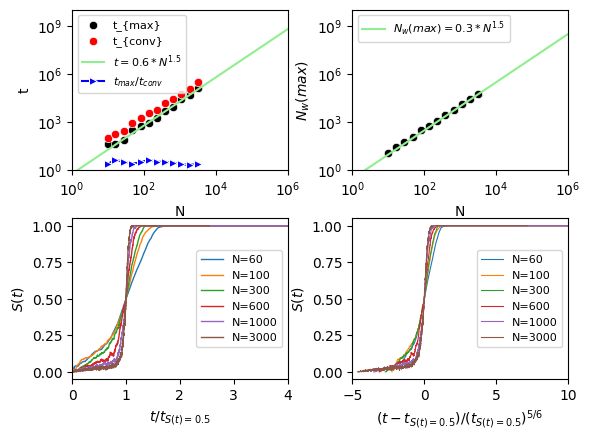

In [136]:
fig, axs = plt.subplots(nrows=2, ncols=2)
t_log = n_log #TODO maybe delete this
t_with0 = np.logspace(0, 6, 20, base=10, dtype=int)
t_n = 0.6*t_with0**1.5
t_d = df["conv_time"] / df["max_time"]

#figure showing max time for multiple agents
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')
g = sns.scatterplot(data=df, x=t_log, y=df["max_time"], ax=axs[0, 0], color="black", label=r't_{max}')
g = sns.scatterplot(data=df, x=t_log, y=df["conv_time"], ax=axs[0, 0], color="red", label=r't_{conv}')
g = sns.lineplot(x=t_with0, y=t_n, ax=axs[0, 0], color="lightgreen", label=r'$t = 0.6*N^{1.5}$')
g = sns.lineplot(x=t_log, y=t_d, ax=axs[0, 0], color="blue", marker='>', label=r'$t_{max}/t_{conv}$')
axs[0,0].legend(loc='upper left', fontsize=8)
axs[0,0].set_ylim(1, 1e10)
axs[0,0].set_xlim(1, 1e6)
g.set(ylabel="t", xlabel="N")

#figure showing max words for multiple agents
t_w = 0.3*t_with0**1.5
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
g = sns.scatterplot(data=df, x=t_log, y=df["max_words"], ax=axs[0, 1], color="black")
g = sns.lineplot(x=t_with0, y=t_w, ax=axs[0, 1], color="lightgreen", label=r'$N_{w}(max) = 0.3*N^{1.5}$')
axs[0,1].legend(loc='upper left', fontsize=8)
axs[0,1].set_ylim(1, 1e10)
axs[0,1].set_xlim(1, 1e6)
g.set(ylabel=r'$N_{w}(max)$', xlabel="N")

t_lin = np.linspace(0, len(s_t_list[0])-1, len(s_t_list[0]))
#figure showing S(t) for multiple agents normalized to st=0.5
for i, st in enumerate(s_t_list):
    closest_idx = np.argmin(np.abs(st-0.5))
    t_at_0_5 = t_lin[closest_idx]
    x = t_lin/(t_at_0_5)
    g = sns.lineplot(x=x, y=st, ax=axs[1, 0], linewidth=1, label=f'N={n_st[i]}')
axs[1,0].legend(loc='center right', fontsize=8)
g.set(ylabel=r'$S(t)$', xlabel=r'$t/t_{S(t)=0.5}$')
axs[1,0].set_xlim(0, 4)

#figure showing S(t) for multiple agents normalized to t-t at 0.5 / t at 0.5 to the power of 5/6
for i, st in enumerate(s_t_list):
    closest_idx = np.argmin(np.abs(st-0.5))
    t_at_0_5 = t_lin[closest_idx]
    x = (t_lin-t_at_0_5)/(t_at_0_5**(5/6))
    g = sns.lineplot(x=x, y=st, ax=axs[1, 1], linewidth=0.8, label=f'N={n_st[i]}')
axs[1,1].legend(loc='center right', fontsize=8)
g.set(ylabel=r'$S(t)$', xlabel=r'$(t-t_{S(t)=0.5})/(t_{S(t)=0.5})^{5/6}$')
axs[1,1].set_xlim(-5, 10)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

The implementation faithfully recreates the key results from the Baronchelli paper, showing how the system undergoes a sharp transition from disorder to order, with characteristic times scaling as N^1.5 and the transition becoming increasingly abrupt for larger systems.

Each section of the code implements specific aspects of the theoretical model described in the paper, and together they demonstrate the emergent behavior of vocabulary convergence in a multi-agent system without central coordination.